<a href="https://colab.research.google.com/github/megnaanand/climate-change-analysis/blob/main/climate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd '/content/drive/My Drive/climate-change-analysis'

/content/drive/My Drive/climate-change-analysis


## 1. Introduction

This data exploration and inference project aims to uncover correlations between environmental changes and a global rise in temperatures over the years 1880 to 2020, utilizing datasets provided by NASA Climate Change.

## 2. Data Collection and Preprocessing
 We will be using  information about global Carbon Dioxide and Methane levels, Global Temperature, Ocean Warming, Ice Sheets Sea Levels, and Arctic Sea Ice levels.


### 2.1. Data Collection


In [9]:
df_ice_sheets = pd.read_csv("data/ice_sheets.txt", delim_whitespace=True)
df_c02_levels = pd.read_csv("data/c02_levels.txt", delim_whitespace=True)
df_methane = pd.read_csv("data/methane.txt", delim_whitespace=True)
df_sea_levels = pd.read_csv("data/sea_levels.txt", delim_whitespace=True)
df_ocean_warming = pd.read_json("data/ocean_warming.json", orient='index')
df_arctic_sea_ice = pd.read_excel("data/arctic_sea_ice.xlsx", index_col=0)
df_global_temperatures = pd.read_csv("data/global_temperatures.txt", delim_whitespace=True)

### 2.2. Data Preprocessing


In [10]:
df_ice_sheets['TIME(year.decimal)'] = df_ice_sheets['TIME(year.decimal)'].astype(int)
df_ice_sheets = df_ice_sheets.groupby('TIME(year.decimal)').mean().reset_index()
df_ice_sheets = df_ice_sheets.rename(columns={'TIME(year.decimal)': 'Year'})
df_ice_sheets = df_ice_sheets.rename(columns={'TIME(year.decimal)': 'Year', 'Antarctic-mass(Gigatonnes)': 'Antarctic Ice Mass Lost Since 2002 (GT)', 'Antarctic-mass-1-sigma-uncertainty(Gigatonnes)': 'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'})
df_ice_sheets.head()

,Year,Antarctic Ice Mass Lost Since 2002 (GT),"Antarctic Ice Mass Loss Uncertainty (STD 1, GT)"
0,2002,-7.431429,91.620000
1,2003,-114.470000,44.167273
2,2004,-260.975000,37.161667
3,2005,-227.801667,34.594167
4,2006,-129.412500,36.380000


In [11]:
df_c02_levels = df_c02_levels.groupby('date').mean().reset_index()
df_c02_levels = df_c02_levels.drop(['month', 'decimal-date', 'days', 'st-dev-days', 'unc-of-mon-mean'], axis=1)
df_c02_levels = df_c02_levels.rename(columns={'date': 'Year', 'monthly-avg': 'CO2 Average Level (PPM)', 'de-season-alized': 'CO2 Average Level De-Seasonalized (PPM)'})
df_c02_levels.head()

,Year,CO2 Average Level (PPM),CO2 Average Level De-Seasonalized (PPM)
0,1958,315.232000,315.292000
1,1959,315.980833,315.977500
2,1960,316.910000,316.907500
3,1961,317.644167,317.640833
4,1962,318.454167,318.448333


In [12]:
df_global_temperatures = df_global_temperatures.rename(columns={'No_Smoothing': 'Raw Global Temperature Anomaly (C)', 'Lowess(5)':'Smoothed Global Temperature Anomaly (C)'})
df_global_temperatures.head()

,Year,Raw Global Temperature Anomaly (C),Smoothed Global Temperature Anomaly (C)
0,1880,-0.17,-0.10
1,1881,-0.09,-0.13
2,1882,-0.11,-0.17
3,1883,-0.18,-0.21
4,1884,-0.29,-0.24


In [13]:
df_methane = df_methane.rename(columns={'year': 'Year', 'mean': 'Average Methane Level (PPB)', 'unc':'Methane Level Uncertainty (1 STD, PPB)'})
df_methane.head()

,Year,Average Methane Level (PPB),"Methane Level Uncertainty (1 STD, PPB)"
0,1984,1644.85,0.67
1,1985,1657.29,0.59
2,1986,1670.09,0.74
3,1987,1682.70,0.49
4,1988,1693.16,0.67


This section takes relevant columns for the Global Mean Sea Levels and organizes it by year. GIA is Glacial Isostatic Adjustment (GIA), or the slow rising or sinking of land once burdened by ice sheets or glaciers. "No GIA" means this data does not account for these land level changes, and "GIA" means it does.

In [14]:
df_sea_levels['year_fraction_of_year'] = df_sea_levels['year_fraction_of_year'].astype(int)
df_sea_levels = df_sea_levels.groupby('year_fraction_of_year').mean().reset_index()
df_sea_levels = df_sea_levels.drop(['altimeter_type', 'merged_file_cycle_#', 'number_of_observations', 'number_weighted_observations'], axis=1)
rename_columns = {
    'year_fraction_of_year': 'Year',
    'GMSL_no_GIA_mm': 'Global Mean Sea Level (mm, No GIA)',
    'standard_deviation_GMSL_no_GIA_mm': 'Standard Deviation of GMSL (mm, No GIA)',
    'smoothed_GMSL_no_GIA': 'Smoothed GMSL (No GIA)',
    'GMSL_GIA_mm': 'Global Mean Sea Level (mm, With GIA)',
    'standard_deviation_GMSL_GIA_mm': 'Standard Deviation of GMSL (mm, With GIA)',
    'smoothed_GMSL_GIA_mm': 'Smoothed GMSL (With GIA)',
    'smoothed_GMSL_GIA_annual_semi_removed_mm': 'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)',
    'smoothed_GMSL_no_GIA_annual_semi_removed_mm': 'Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'
}
df_sea_levels.rename(columns=rename_columns, inplace=True)
df_sea_levels.head()

,Year,"Global Mean Sea Level (mm, No GIA)","Standard Deviation of GMSL (mm, No GIA)",Smoothed GMSL (No GIA),"Global Mean Sea Level (mm, With GIA)","Standard Deviation of GMSL (mm, With GIA)",Smoothed GMSL (With GIA),"Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)","Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)"
0,1993,-34.625676,87.608919,-34.650000,-34.504054,87.612432,-34.528108,-34.528108,-34.649459
1,1994,-30.970270,87.426216,-30.918649,-30.604054,87.432162,-30.552432,-30.551892,-30.918108
2,1995,-28.662973,85.356757,-27.987027,-28.038108,85.357297,-27.376486,-27.375405,-27.986216
3,1996,-26.613611,84.227222,-26.158056,-25.761111,84.221944,-25.305556,-25.304722,-26.157222
4,1997,-22.696216,98.027027,-22.361622,-21.605946,98.040541,-21.270811,-21.271622,-22.363514


In [15]:
df_ocean_warming.reset_index(inplace=True)
df_ocean_warming.columns = ['Year', 'Data']
df_ocean_warming['Year'] = pd.to_datetime(df_ocean_warming['Year']).dt.year
df_ocean_warming['Year'] = df_ocean_warming['Year'].astype(int)
df_ocean_warming = df_ocean_warming.groupby('Year').mean().reset_index()
df_ocean_warming = df_ocean_warming.rename(columns={'Data': 'Ocean Warming (ZJ)'})
df_ocean_warming.head()

,Year,Ocean Warming (ZJ)
0,1992,-10.881634
1,1993,-13.388852
2,1994,-2.664185
3,1995,5.064039
4,1996,15.332920


In [16]:
df_arctic_sea_ice.head()
df_arctic_sea_ice = df_arctic_sea_ice.drop(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], axis=1).reset_index()
df_arctic_sea_ice = df_arctic_sea_ice.rename(columns={'Year': 'Year', 'Annual': 'Arctic Sea Ice Extent (Millions of KM^2)'})
df_arctic_sea_ice.head()


,Year,Arctic Sea Ice Extent (Millions of KM^2)
0,1978,12.673
1,1979,12.328
2,1980,12.337
3,1981,12.127
4,1982,12.447


### 2.3. Data Integration
Combine different datasets into a cohesive format.


In [17]:
merged_df = pd.merge(df_ice_sheets, df_global_temperatures, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_methane, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_sea_levels, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_ocean_warming, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_arctic_sea_ice, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_c02_levels, on='Year', how='outer')
merged_df = merged_df.sort_values(by='Year')

In [18]:
pd.set_option('display.max_columns', None)
print(merged_df.shape)
merged_df.head()

(144, 19)


,Year,Antarctic Ice Mass Lost Since 2002 (GT),"Antarctic Ice Mass Loss Uncertainty (STD 1, GT)",Raw Global Temperature Anomaly (C),Smoothed Global Temperature Anomaly (C),Average Methane Level (PPB),"Methane Level Uncertainty (1 STD, PPB)","Global Mean Sea Level (mm, No GIA)","Standard Deviation of GMSL (mm, No GIA)",Smoothed GMSL (No GIA),"Global Mean Sea Level (mm, With GIA)","Standard Deviation of GMSL (mm, With GIA)",Smoothed GMSL (With GIA),"Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)","Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)",Ocean Warming (ZJ),Arctic Sea Ice Extent (Millions of KM^2),CO2 Average Level (PPM),CO2 Average Level De-Seasonalized (PPM)
22,1880,NaN,NaN,-0.17,-0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,1881,NaN,NaN,-0.09,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,1882,NaN,NaN,-0.11,-0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,1883,NaN,NaN,-0.18,-0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,1884,NaN,NaN,-0.29,-0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4 Data Cleaning/Adjusting Data

This dataframe only contains years of data in which all of the features are present.

In [19]:
merged_df_no_nan = merged_df.dropna()
print(merged_df_no_nan.shape)
merged_df_no_nan.head()

(18, 19)


,Year,Antarctic Ice Mass Lost Since 2002 (GT),"Antarctic Ice Mass Loss Uncertainty (STD 1, GT)",Raw Global Temperature Anomaly (C),Smoothed Global Temperature Anomaly (C),Average Methane Level (PPB),"Methane Level Uncertainty (1 STD, PPB)","Global Mean Sea Level (mm, No GIA)","Standard Deviation of GMSL (mm, No GIA)",Smoothed GMSL (No GIA),"Global Mean Sea Level (mm, With GIA)","Standard Deviation of GMSL (mm, With GIA)",Smoothed GMSL (With GIA),"Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)","Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)",Ocean Warming (ZJ),Arctic Sea Ice Extent (Millions of KM^2),CO2 Average Level (PPM),CO2 Average Level De-Seasonalized (PPM)
0,2002,-7.431429,91.620000,0.62,0.54,1772.66,0.55,-9.380000,85.393056,-9.390556e+00,-7.065833,85.449444,-7.076667,-7.076111,-9.390278,63.085198,11.363,373.452500,373.452500
1,2003,-114.470000,44.167273,0.62,0.58,1777.33,0.50,-6.321622,86.547297,-6.264324e+00,-3.766757,86.612703,-3.708919,-3.710270,-6.265135,69.738707,11.397,375.983333,375.983333
2,2004,-260.975000,37.161667,0.53,0.60,1777.05,0.50,-4.430270,85.545135,-4.550811e+00,-1.627568,85.564865,-1.749189,-1.749189,-4.551081,76.696781,11.240,377.698333,377.697500
3,2005,-227.801667,34.594167,0.67,0.61,1774.16,0.64,-0.030811,84.578108,-6.001206e-18,3.014054,84.549730,3.044595,3.044054,0.000000,79.527011,10.907,379.982500,379.982500
4,2006,-129.412500,36.380000,0.63,0.62,1774.95,0.56,1.093889,85.335833,1.115833e+00,4.375000,85.337222,4.396944,4.507778,1.227222,84.202106,10.773,382.090833,382.089167


This dataframe only considers the averages of each features. In most cases the smoothed average was taken if provided.

In [20]:
averages_df = merged_df.dropna()
columns_for_averages = ['Antarctic Ice Mass Lost Since 2002 (GT)',
                        'Raw Global Temperature Anomaly (C)',
                        'Smoothed Global Temperature Anomaly (C)',
                        'Average Methane Level (PPB)',
                        'Global Mean Sea Level (mm, No GIA)',
                        'Smoothed GMSL (No GIA)',
                        'Global Mean Sea Level (mm, With GIA)',
                        'Smoothed GMSL (With GIA)',
                    	'Ocean Warming (ZJ)',
                        'Arctic Sea Ice Extent (Millions of KM^2)',
                        'CO2 Average Level (PPM)',
                        'CO2 Average Level De-Seasonalized (PPM)']

df_averages = merged_df[columns_for_averages].copy()
df_averages.head()

,Antarctic Ice Mass Lost Since 2002 (GT),Raw Global Temperature Anomaly (C),Smoothed Global Temperature Anomaly (C),Average Methane Level (PPB),"Global Mean Sea Level (mm, No GIA)",Smoothed GMSL (No GIA),"Global Mean Sea Level (mm, With GIA)",Smoothed GMSL (With GIA),Ocean Warming (ZJ),Arctic Sea Ice Extent (Millions of KM^2),CO2 Average Level (PPM),CO2 Average Level De-Seasonalized (PPM)
22,NaN,-0.17,-0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,-0.09,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,-0.11,-0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,-0.18,-0.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,-0.29,-0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Exploratory Data Analysis (EDA)

### 3.1. Initial Data Exploration
Use basic statistics and visualizations to understand the datasets.

#### 3.1.1. Analysis on Antarctic Ice Mass Loss

This data measures the amount of ice mass the Antarctic has lost in gigatonnes since 2002.

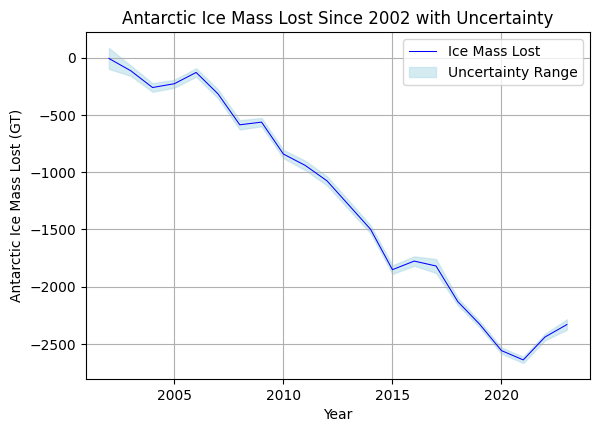

In [21]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_ice_sheets['Year'], df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'], label='Ice Mass Lost', color='blue', linewidth=0.75)
plt.fill_between(df_ice_sheets['Year'],
                 df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'] - df_ice_sheets['Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'],
                 df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'] + df_ice_sheets['Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.title('Antarctic Ice Mass Lost Since 2002 with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Antarctic Ice Mass Lost (GT)')
plt.legend()
plt.grid(True)
plt.show()

Plotting the average ice mass lost in the Antarctic with the uncertainty behind it, we can see that there has been a negative correlation between ice lost and the year, indicating that as time passes, we have lost more and more antarctic ice.

#### 3.1.2 Analysis on Global Temperature Anomaly

The global temperature anomaly measures the change in global surface temperature compared to the long-term average from 1951 to 1980.

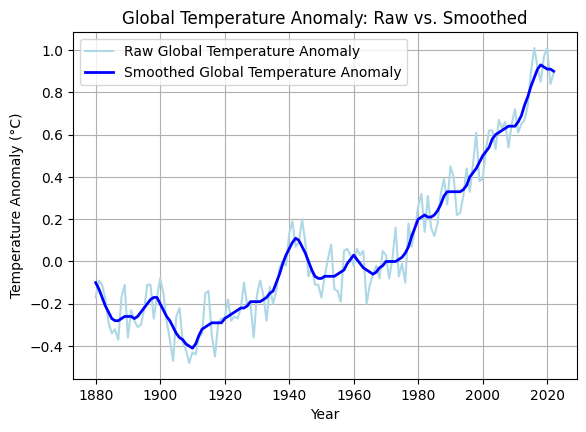

In [22]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Raw Global Temperature Anomaly (C)'], label='Raw Global Temperature Anomaly', color='lightblue')
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Smoothed Global Temperature Anomaly (C)'], label='Smoothed Global Temperature Anomaly', color='blue', linewidth=2)
plt.title('Global Temperature Anomaly: Raw vs. Smoothed')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.show()

Plotting the smoothed global temperature anomaly, we can see the general trend of the temperature anomaly that the raw data shows as well. This shows a clear positive correlation between year and the temperature anomaly, indicating the temperatures have departed significantly from the average in the 1950s-1980s over time.

#### 3.1.3 Analysis on Carbon Dioxide Levels

This data measures the average CO2 levels since 1958 in parts per million.

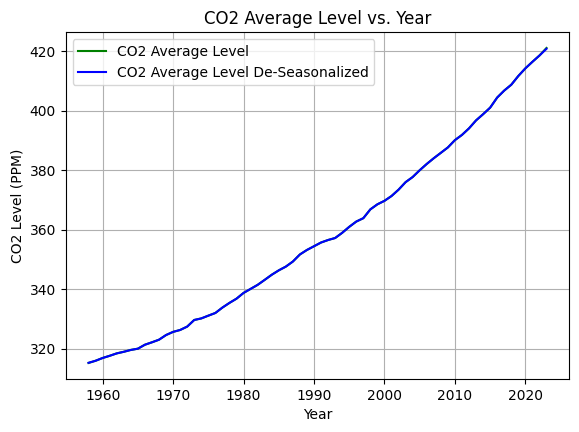

In [23]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_c02_levels['Year'], df_c02_levels['CO2 Average Level (PPM)'], label='CO2 Average Level', color='green')
plt.plot(df_c02_levels['Year'], df_c02_levels['CO2 Average Level De-Seasonalized (PPM)'], label='CO2 Average Level De-Seasonalized', color='blue')
plt.title('CO2 Average Level vs. Year')
plt.xlabel('Year')
plt.ylabel('CO2 Level (PPM)')
plt.legend()
plt.grid(True)
plt.show()

Here, we can see a clear positive correlation between the year and the CO2 levels, indicating that as time has gone by, carbon dioxide levels have increased.

#### 3.1.3 Analysis on Average Methane Levels

This data plots the average methane level in parts per billion.

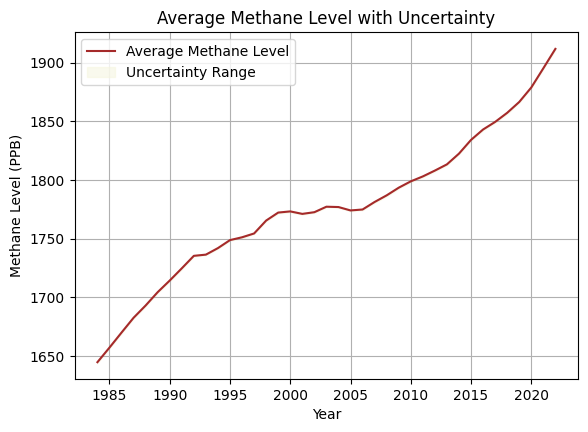

In [24]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_methane['Year'], df_methane['Average Methane Level (PPB)'], label='Average Methane Level', color='brown')
plt.fill_between(df_methane['Year'],
                 df_methane['Average Methane Level (PPB)'] - df_methane['Methane Level Uncertainty (1 STD, PPB)'],
                 df_methane['Average Methane Level (PPB)'] + df_methane['Methane Level Uncertainty (1 STD, PPB)'],
                 color='beige', alpha=0.5, label='Uncertainty Range')
plt.title('Average Methane Level with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

We can see a clear positive correlation and increase in methane levels over time.

#### 3.1.4 Analysis on Global Mean Sea Level

This section takes relevant columns for the Global Mean Sea Levels and organizes it by year. GIA is Glacial Isostatic Adjustment (GIA), or the slow rising or sinking of land once burdened by ice sheets or glaciers. "No GIA" means this data does not account for these land level changes, and "GIA" means it does.

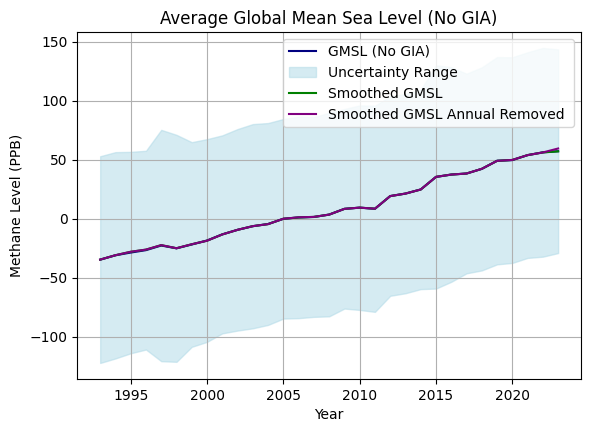

In [25]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_sea_levels['Year'], df_sea_levels['Global Mean Sea Level (mm, No GIA)'], label='GMSL (No GIA)', color='navy')
plt.fill_between(df_sea_levels['Year'],
                 df_sea_levels['Global Mean Sea Level (mm, No GIA)'] - df_sea_levels['Standard Deviation of GMSL (mm, No GIA)'],
                 df_sea_levels['Global Mean Sea Level (mm, No GIA)'] + df_sea_levels['Standard Deviation of GMSL (mm, No GIA)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL (No GIA)'], label = 'Smoothed GMSL', color = 'green')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'], label = 'Smoothed GMSL Annual Removed ', color = 'purple')
plt.title('Average Global Mean Sea Level (No GIA)')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

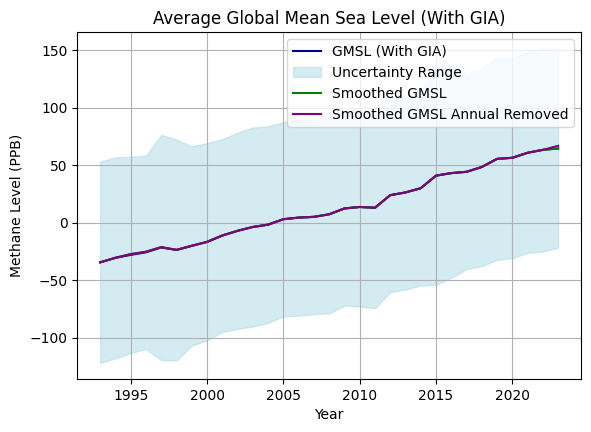

In [26]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_sea_levels['Year'], df_sea_levels['Global Mean Sea Level (mm, With GIA)'], label='GMSL (With GIA)', color='navy')
plt.fill_between(df_sea_levels['Year'],
                 df_sea_levels['Global Mean Sea Level (mm, With GIA)'] - df_sea_levels['Standard Deviation of GMSL (mm, With GIA)'],
                 df_sea_levels['Global Mean Sea Level (mm, With GIA)'] + df_sea_levels['Standard Deviation of GMSL (mm, With GIA)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL (With GIA)'], label = 'Smoothed GMSL', color = 'green')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)'], label = 'Smoothed GMSL Annual Removed', color = 'purple')
plt.title('Average Global Mean Sea Level (With GIA)')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

Even though this is a large area of uncertainty, there seems to be a clear positive correlation for all of the measured values, which indicates that methane levels have increased over time.

#### 3.1.5 Analysis on Ocean Warming

This data measures the ocean warming in zettajoules per year.

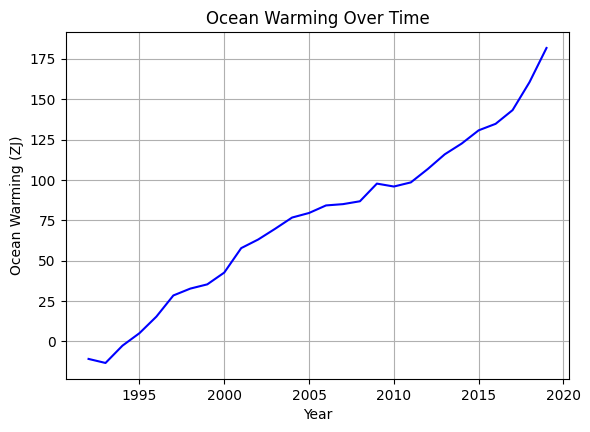

In [27]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_ocean_warming['Year'], df_ocean_warming['Ocean Warming (ZJ)'], label='Ocean Warming', color='blue')
plt.title('Ocean Warming Over Time')
plt.xlabel('Year')
plt.ylabel('Ocean Warming (ZJ)')
plt.grid(True)
plt.show()

There seems to be a clear amount of ocean warming over the years that it was measured, indicating that oceans have gotten warmer over time.

#### 3.1.6. Analysis on Arctic Sea Ice Extent

This data measures the arctic sea ice extend in millions of killometers squared.

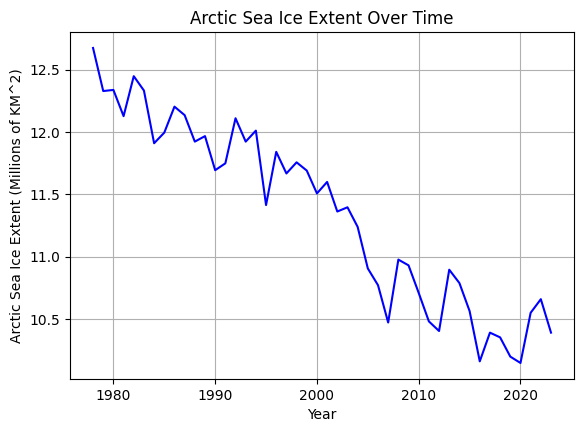

In [28]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_arctic_sea_ice['Year'], df_arctic_sea_ice['Arctic Sea Ice Extent (Millions of KM^2)'],
         label='Arctic Sea Ice Extent', color='blue')
plt.title('Arctic Sea Ice Extent Over Time')
plt.xlabel('Year')
plt.ylabel('Arctic Sea Ice Extent (Millions of KM^2)')
plt.grid(True)
plt.show()

We can see a clear negative correlation between years and arctic sea ice extent, indicating that it has decreased over time.

### 3.2. Global Temperature Data Analysis



Our project aims to focus on understanding major changes in global temperatures and understanding what may cause significant changes in global temperature and how these correlate. In this section, we'll be looking at the trends of global temperature and highlighting anomalies in the data.

In [29]:
df_global_temperatures.head()

,Year,Raw Global Temperature Anomaly (C),Smoothed Global Temperature Anomaly (C)
0,1880,-0.17,-0.10
1,1881,-0.09,-0.13
2,1882,-0.11,-0.17
3,1883,-0.18,-0.21
4,1884,-0.29,-0.24


#### 3.2.1. Time Series Decomposition

Time series decomposition is a statistical technique used to separate a time series data set into 4 components:

Trend: The first component represents the long-term progression/trend of the series. Observing the trend component can provide insights into long-term changes or movements in the data, such as a gradual increase in global temperatures over several decades.

Seasonal: The second component patterns that repeat at regular intervals (such as seasonal patterns).

Residual (or Irregular): This component is what remains after the trend and seasonal components have been removed from the data. It represents the randomness or noise in the data. Analyzing the residuals can help in understanding the unexplained variance in the data and identifying anomalies or outliers.

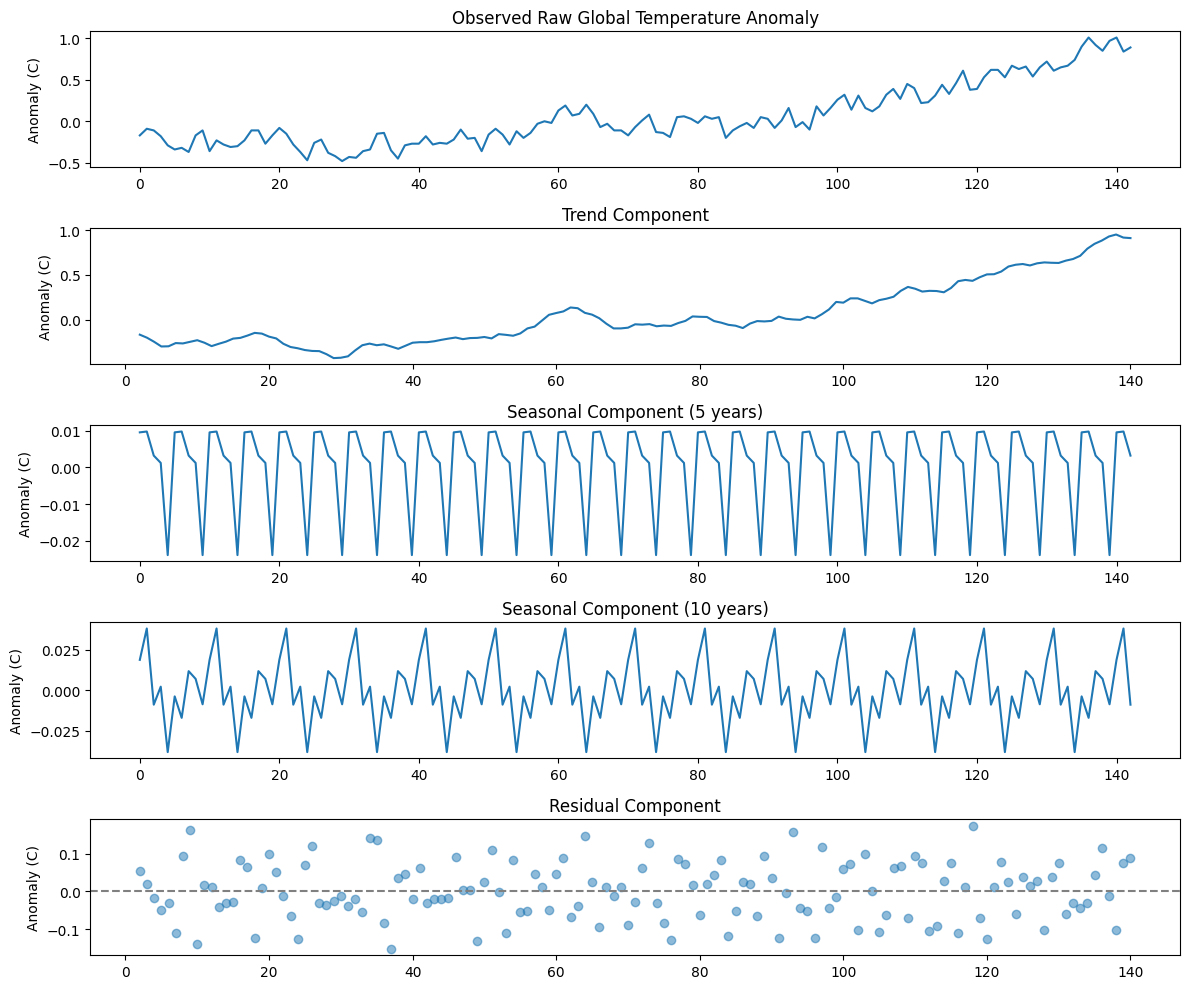

In [30]:
decomposition = sm.tsa.seasonal_decompose(df_global_temperatures['Raw Global Temperature Anomaly (C)'], model='additive', period=5)
decomposition_short = sm.tsa.seasonal_decompose(df_global_temperatures['Raw Global Temperature Anomaly (C)'], model='additive', period=10)

fig, axes = plt.subplots(5, 1, figsize=(12, 10))

axes[0].plot(decomposition.observed)
axes[0].set_title('Observed Raw Global Temperature Anomaly')
axes[0].set_ylabel('Anomaly (C)')

axes[1].plot(decomposition.trend)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Anomaly (C)')

axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonal Component (5 years)')
axes[2].set_ylabel('Anomaly (C)')

axes[3].plot(decomposition_short.seasonal)
axes[3].set_title('Seasonal Component (10 years)')
axes[3].set_ylabel('Anomaly (C)')

axes[4].scatter(df_global_temperatures.index, decomposition.resid, alpha=0.5)
axes[4].set_title('Residual Component')
axes[4].set_ylabel('Anomaly (C)')
axes[4].axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()


#### 3.2.2. Global Temperature Change Anomalies

This graph finds the change in global temperature every year and specifically highlights anomalies in the data (changes that are more than two standard deviations from the mean change per year).

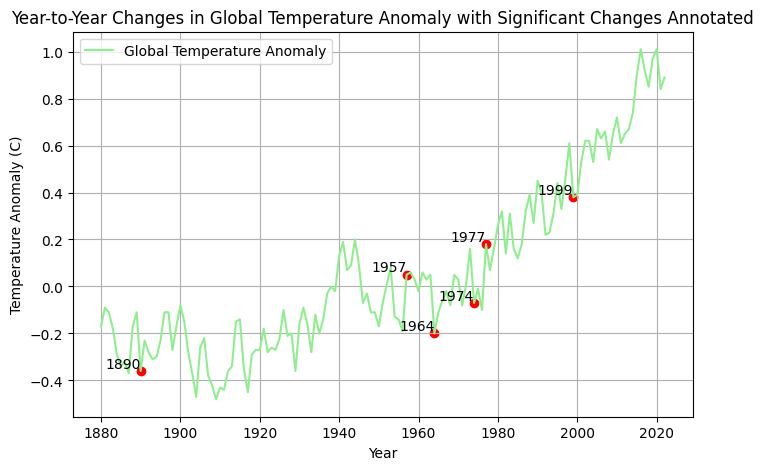

In [31]:
import matplotlib.pyplot as plt

df_global_temperatures['Temp_Change'] = df_global_temperatures['Raw Global Temperature Anomaly (C)'].diff()

std_change = df_global_temperatures['Temp_Change'].std()
threshold_major_change = 2 * std_change

df_global_temperatures['Significant_Change'] = abs(df_global_temperatures['Temp_Change']) > threshold_major_change

plt.figure(figsize=(8, 5))
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Raw Global Temperature Anomaly (C)'], label='Global Temperature Anomaly', color='lightgreen')
for year, temp_anomaly, temp_change, is_significant in df_global_temperatures[['Year', 'Raw Global Temperature Anomaly (C)', 'Temp_Change', 'Significant_Change']].itertuples(index=False):
    if is_significant:
        plt.scatter(year, temp_anomaly, color='red')
        plt.text(year, temp_anomaly, f'{year}', ha='right', va='bottom')

plt.title('Year-to-Year Changes in Global Temperature Anomaly with Significant Changes Annotated')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)')
plt.legend()
plt.grid(True)
plt.show()

#### 3.2.4. Difference in Trends after Significant Natural Global Events

This section of the notebook is analyzes the impact of significant climatic phenomena, El Niño and La Niña, on global temperature anomalies. These events are known to cause substantial deviations in weather patterns across the globe.

El Niño: A climatic event characterized by the warming of the ocean surface temperatures in the central and eastern tropical Pacific Ocean. El Niño events typically lead to significant weather variations, such as increased rainfall in some regions and drought in others, and are associated with warmer global temperatures.

La Niña: The counterpart to El Niño, La Niña is marked by unusually cold ocean temperatures in the Equatorial Pacific. La Niña events often result in opposite weather patterns compared to El Niño, including cooler global temperatures.

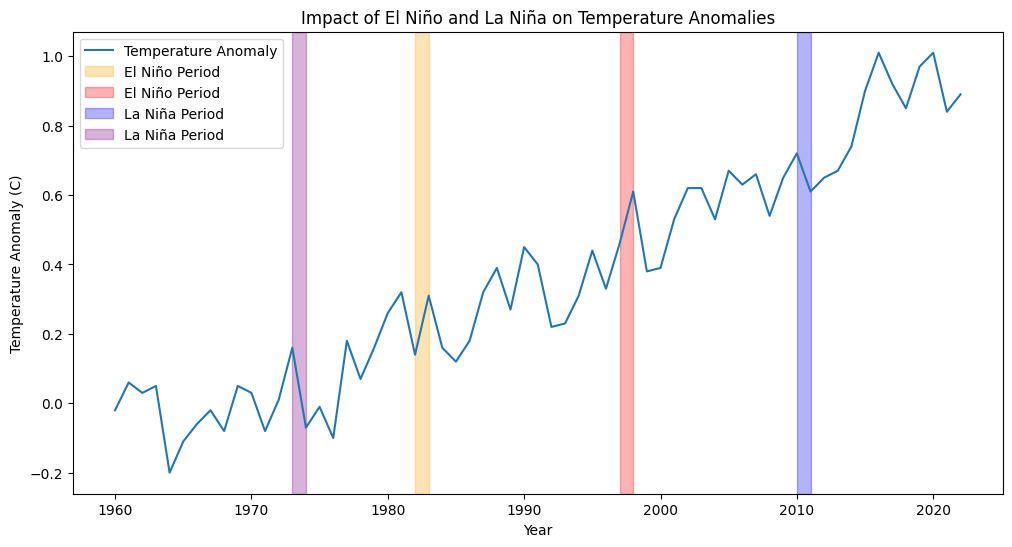

Average temperature anomaly during El Niño (1982-1983): 0.23C
Average temperature anomaly during La Niña (2010-2011): 0.67C
Average temperature anomaly during El Niño (1997-1998): 0.54C
Average temperature anomaly during La Niña (1973-1974): 0.04C


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

el_nino_start, el_nino_end = 1982, 1983
el_nino_start_2, el_nino_end_2 = 1997, 1998
la_nina_start, la_nina_end = 2010, 2011
la_nina_start_2, la_nina_end_2 = 1973, 1974

df_global_temperatures_2 = df_global_temperatures[df_global_temperatures['Year'] >= 1960]

el_nino_period = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= el_nino_start) & (df_global_temperatures_2['Year'] <= el_nino_end)]
la_nina_period = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= la_nina_start) & (df_global_temperatures_2['Year'] <= la_nina_end)]
el_nino_period_2 = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= el_nino_start_2) & (df_global_temperatures_2['Year'] <= el_nino_end_2)]
la_nina_period_2 = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= la_nina_start_2) & (df_global_temperatures_2['Year'] <= la_nina_end_2)]

average_el_nino = el_nino_period['Raw Global Temperature Anomaly (C)'].mean()
average_la_nina = la_nina_period['Raw Global Temperature Anomaly (C)'].mean()
average_el_nino_2 = el_nino_period_2['Raw Global Temperature Anomaly (C)'].mean()
average_la_nina_2 = la_nina_period_2['Raw Global Temperature Anomaly (C)'].mean()

plt.figure(figsize=(12, 6))
plt.plot(df_global_temperatures_2['Year'], df_global_temperatures_2['Raw Global Temperature Anomaly (C)'], label='Temperature Anomaly')
plt.axvspan(el_nino_start, el_nino_end, color='orange', alpha=0.3, label='El Niño Period')
plt.axvspan(el_nino_start_2, el_nino_end_2, color='red', alpha=0.3, label='El Niño Period')
plt.axvspan(la_nina_start, la_nina_end, color='blue', alpha=0.3, label='La Niña Period')
plt.axvspan(la_nina_start_2, la_nina_end_2, color='purple', alpha=0.3, label='La Niña Period')
plt.title('Impact of El Niño and La Niña on Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)')
plt.legend()
plt.show()

print(f"Average temperature anomaly during El Niño (1982-1983): {average_el_nino:.2f}C")
print(f"Average temperature anomaly during La Niña (2010-2011): {average_la_nina:.2f}C")
print(f"Average temperature anomaly during El Niño (1997-1998): {average_el_nino_2:.2f}C")
print(f"Average temperature anomaly during La Niña (1973-1974): {average_la_nina_2:.2f}C")


### 3.3. Correlation Between Environmental Indicators and Global Temperature

#### 3.3.1. Correlation Between Raw Global Temperature Anomalies and All Variables

This code plots the correlation between the Raw Global Temperature departure from mean and all of the environmental variables on a scatter plot to better visualize the strength of the correlation.

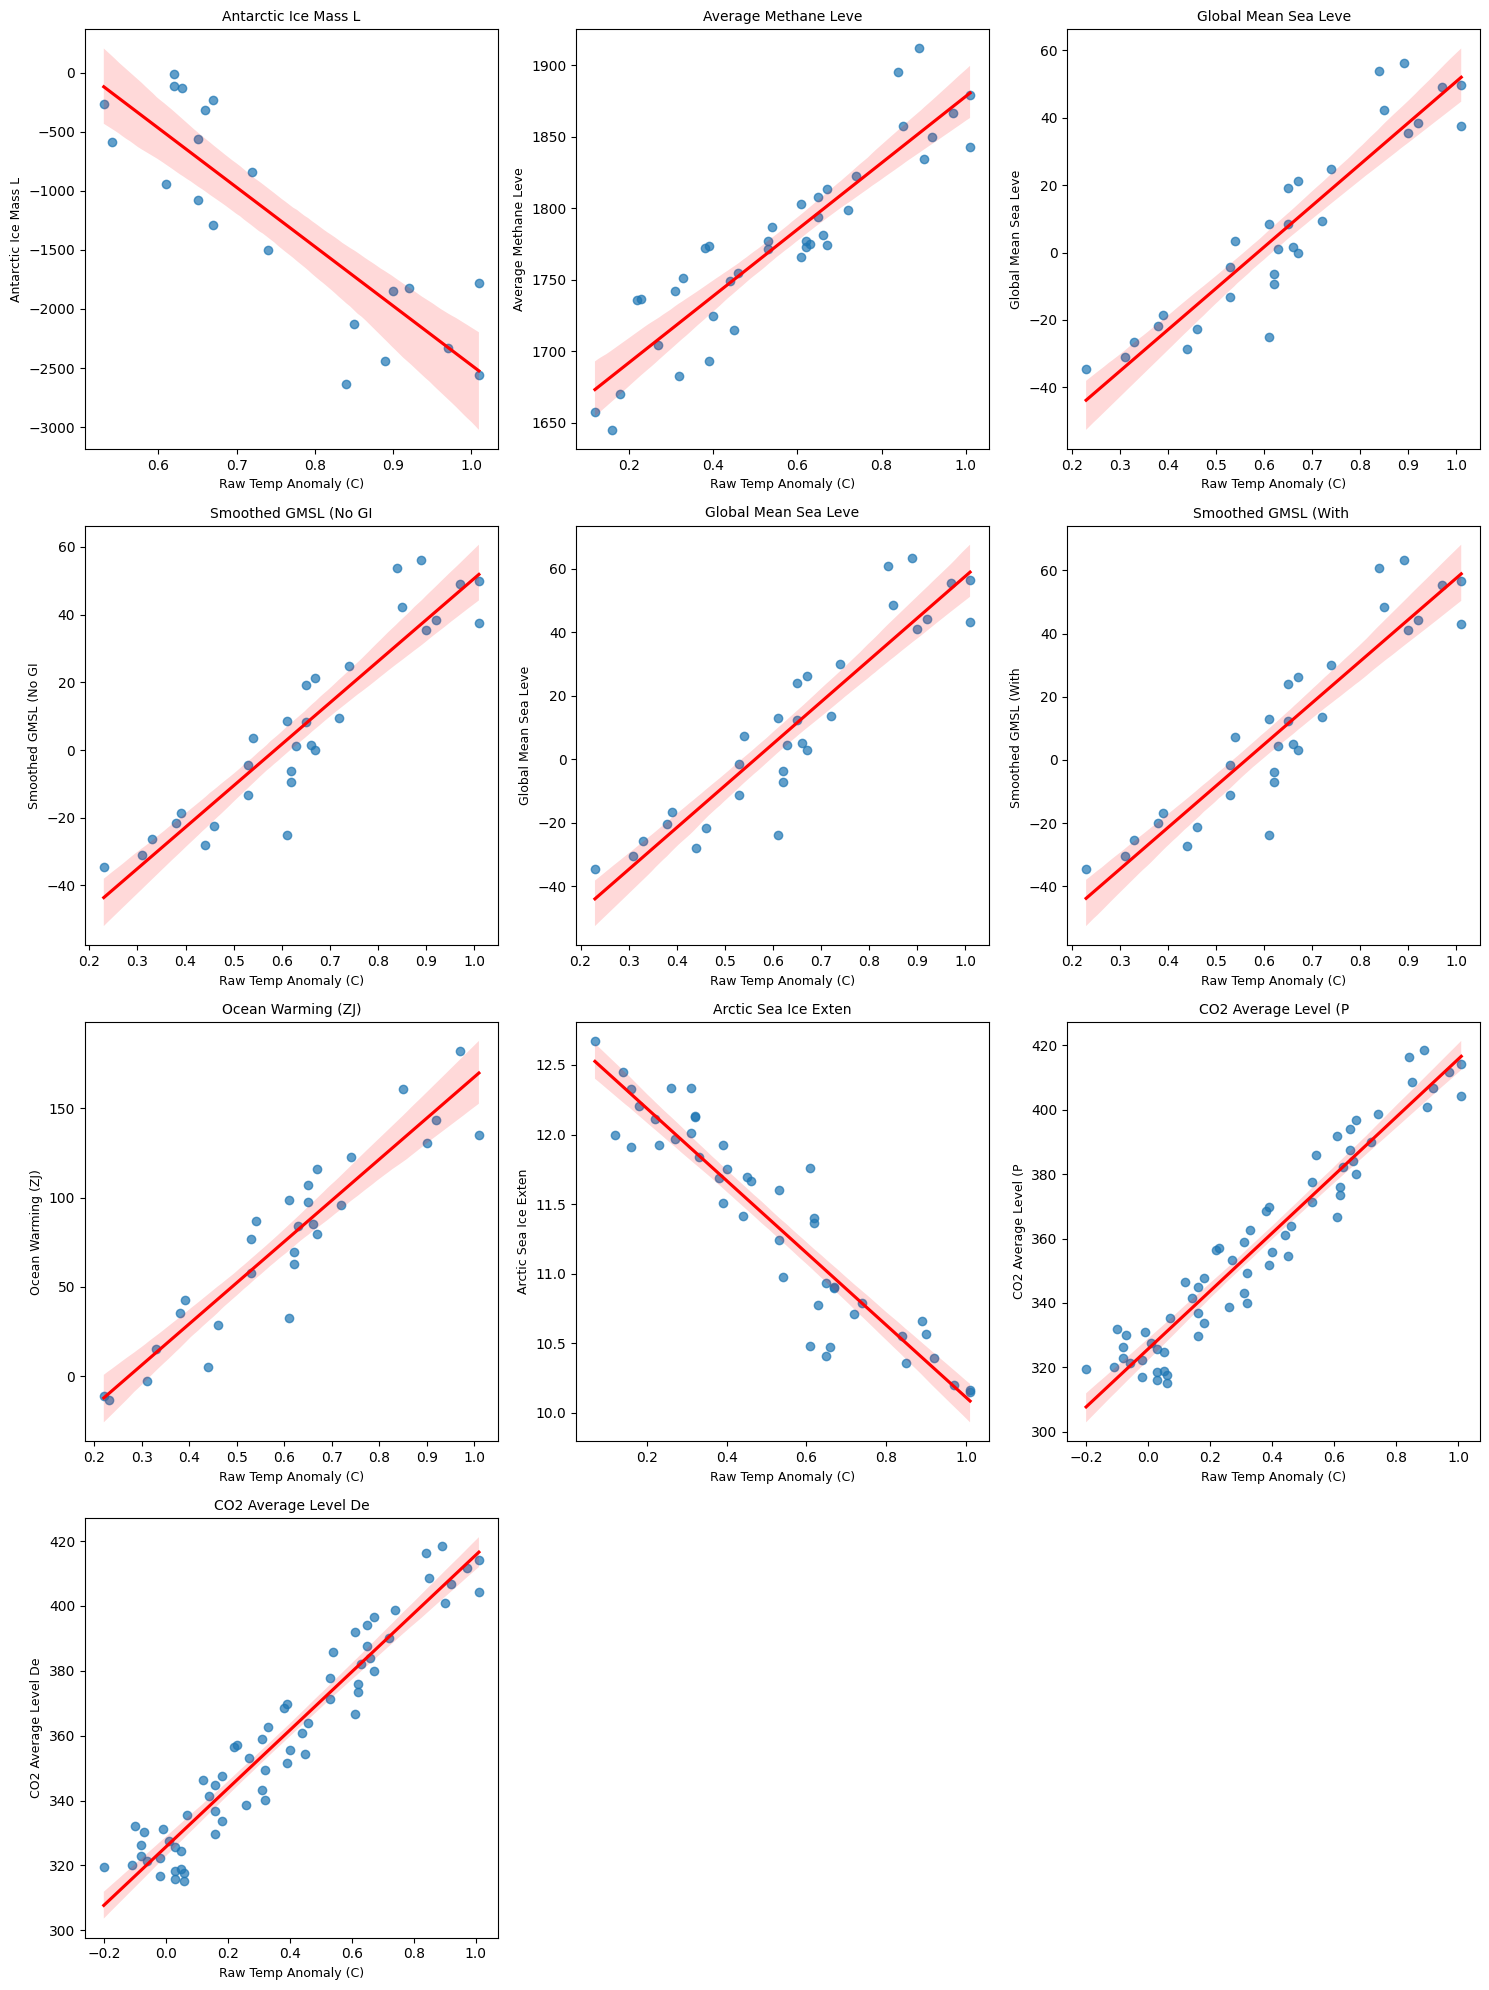

In [33]:
import numpy as np
import seaborn as sns
variables_to_plot = [col for col in df_averages.columns if col not in ['Year', 'Smoothed Global Temperature Anomaly (C)', 'Raw Global Temperature Anomaly (C)']]

n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

axes_flat = axes.flatten()

for i, variable in enumerate(variables_to_plot):
    ax = axes_flat[i]
    sns.regplot(ax=ax, data=df_averages, x='Raw Global Temperature Anomaly (C)', y=variable, scatter_kws={'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(variable[:20], fontsize=10)
    ax.set_xlabel('Raw Temp Anomaly (C)', fontsize=9)
    ax.set_ylabel(variable[:20], fontsize=9)

for ax in axes_flat[i+1:]:
    ax.remove()

plt.tight_layout()
plt.show()


#### 3.3.2. Correlation Between Smoothed Global Temperature Anomalies and All Variables

This code plots the correlation between the Smoothed Global Temperature departure from mean and all of the environmental variables on a scatter plot to better visualize the strength of the correlation.

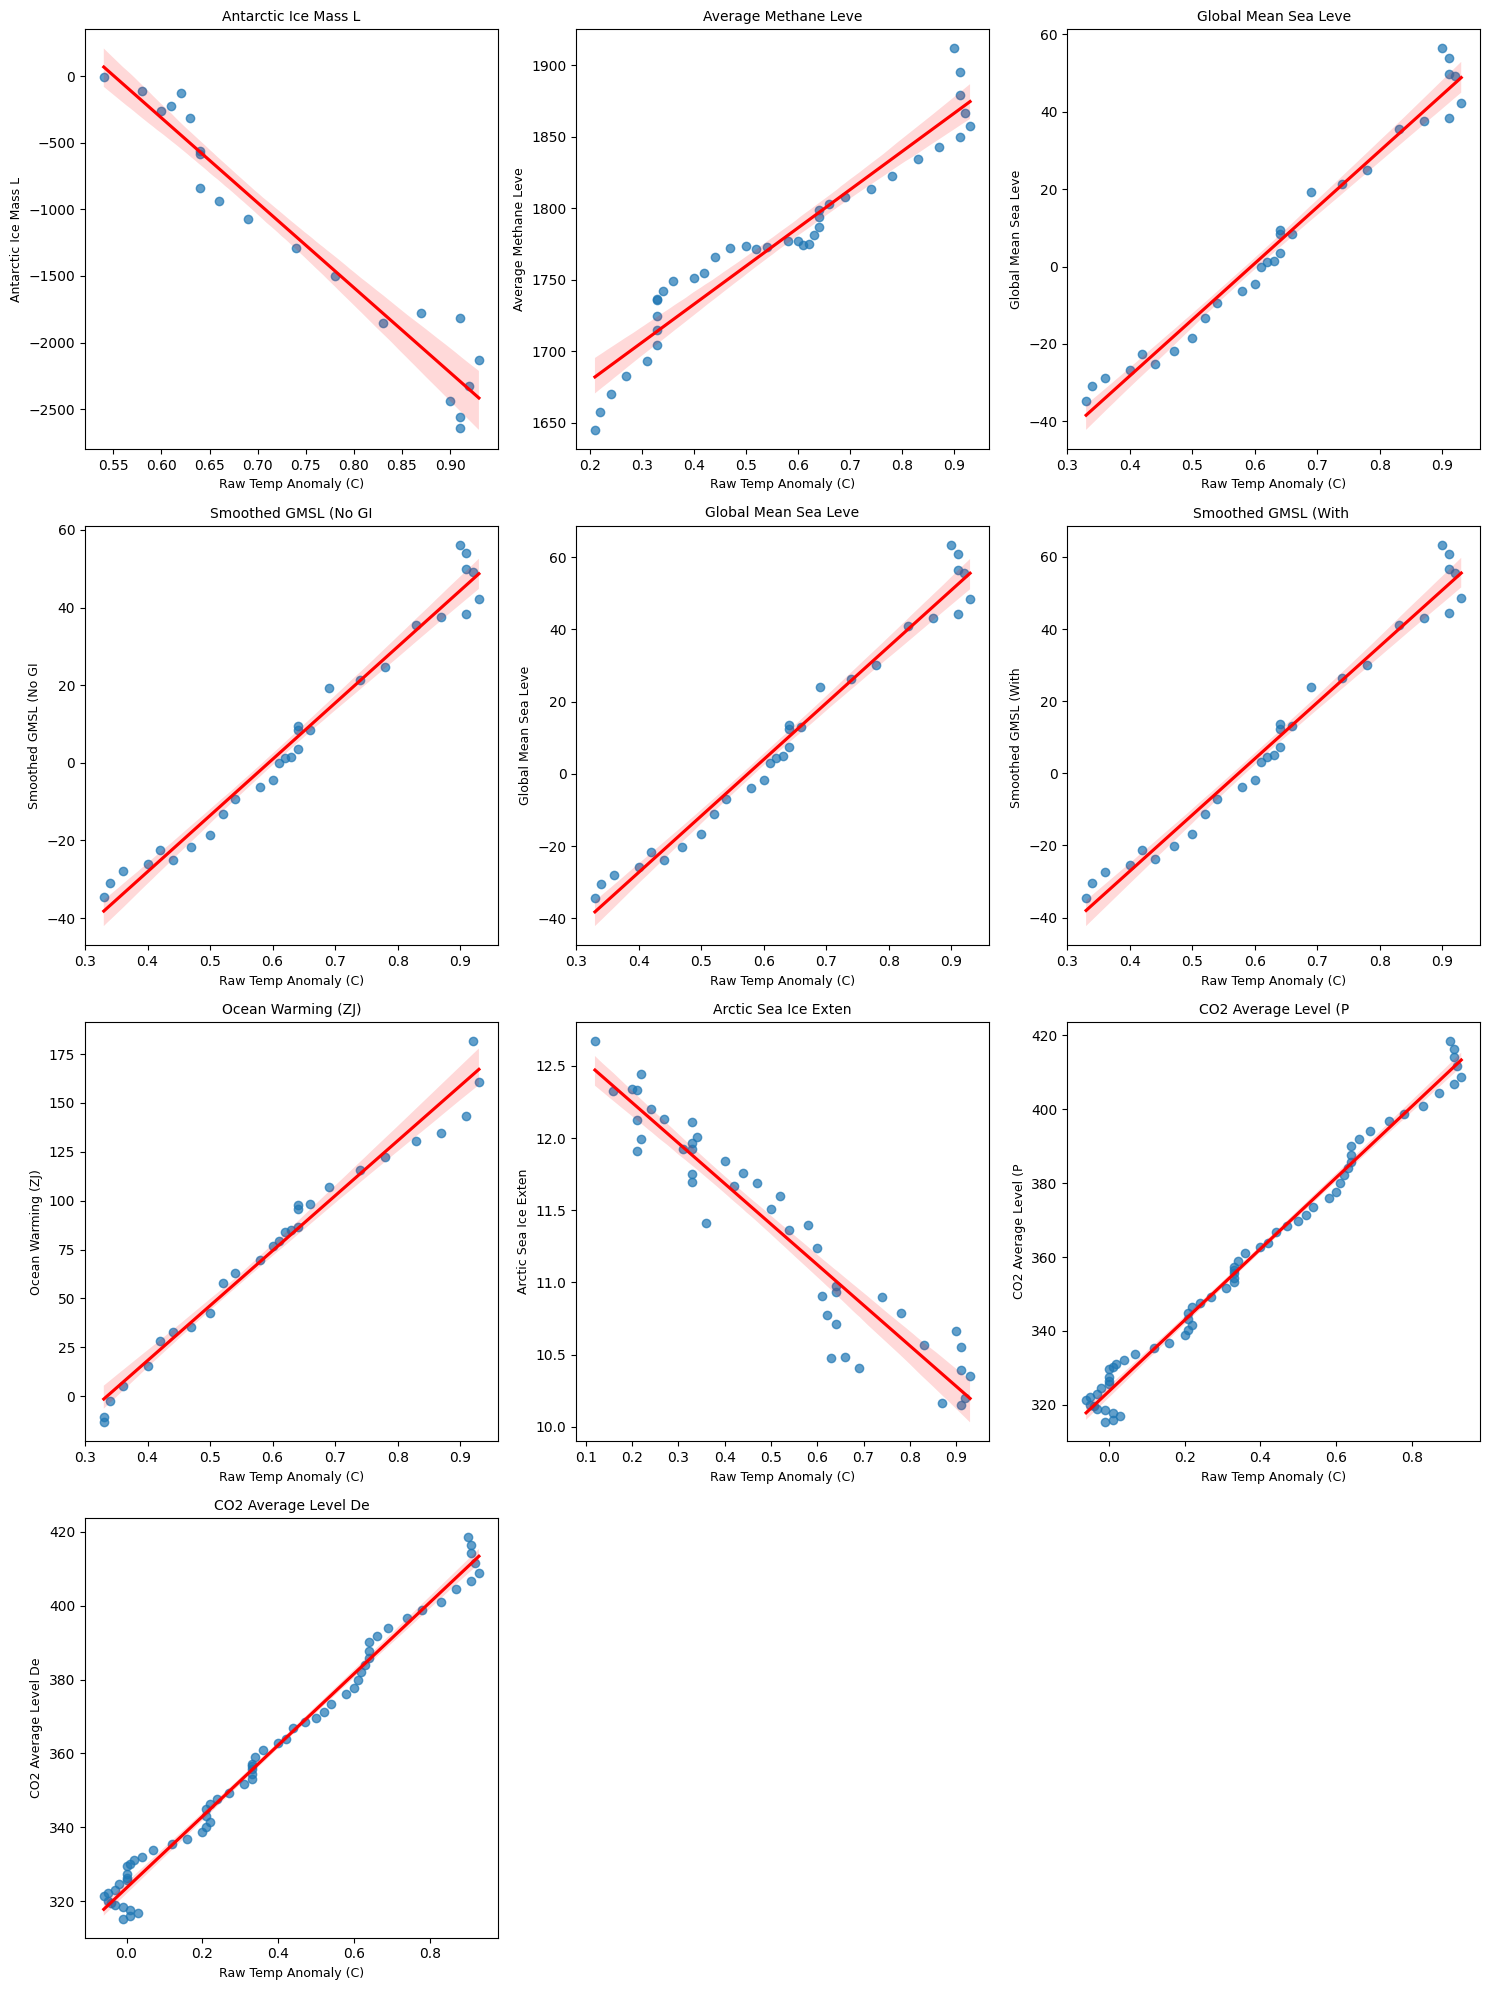

In [34]:
import numpy as np
import seaborn as sns
variables_to_plot = [col for col in df_averages.columns if col not in ['Year', 'Smoothed Global Temperature Anomaly (C)', 'Raw Global Temperature Anomaly (C)']]

n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

axes_flat = axes.flatten()

for i, variable in enumerate(variables_to_plot):
    ax = axes_flat[i]
    sns.regplot(ax=ax, data=df_averages, x='Smoothed Global Temperature Anomaly (C)', y=variable, scatter_kws={'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(variable[:20], fontsize=10)
    ax.set_xlabel('Raw Temp Anomaly (C)', fontsize=9)
    ax.set_ylabel(variable[:20], fontsize=9)

for ax in axes_flat[i+1:]:
    ax.remove()

plt.tight_layout()
plt.show()

#### 3.3.3. Heatmap

This visualizes the correlation strength between the variables in question, where values of magnitude closer to 1 are more correlated.

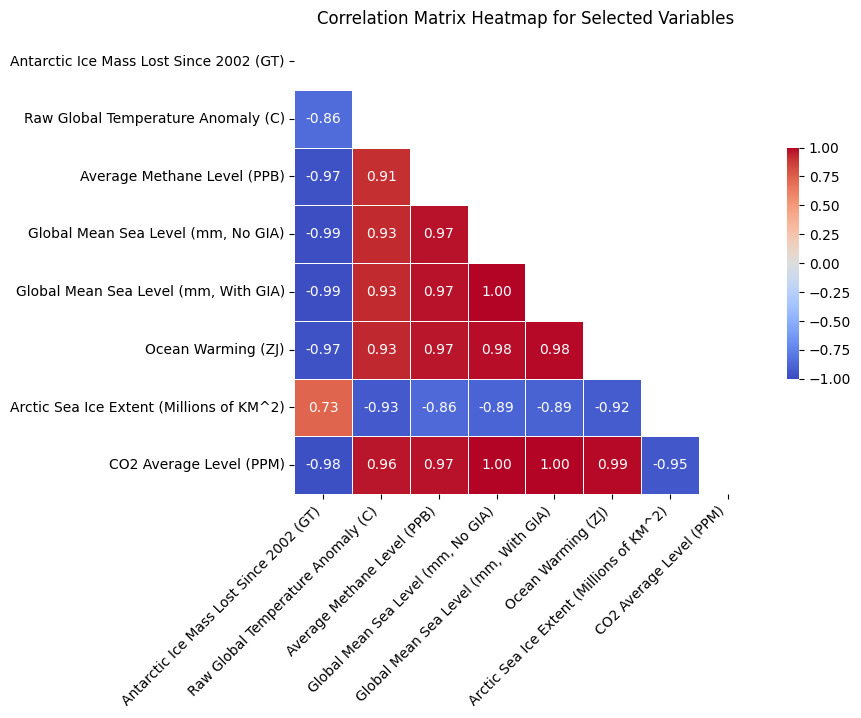

In [35]:
selected_variables = ['Antarctic Ice Mass Lost Since 2002 (GT)',
                        'Raw Global Temperature Anomaly (C)',
                        'Average Methane Level (PPB)',
                        'Global Mean Sea Level (mm, No GIA)',
                        'Global Mean Sea Level (mm, With GIA)',
                    	'Ocean Warming (ZJ)',
                        'Arctic Sea Ice Extent (Millions of KM^2)',
                        'CO2 Average Level (PPM)']

correlation_matrix = df_averages[selected_variables].corr()

mask_upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(correlation_matrix, mask=mask_upper_triangle, cmap='coolwarm', vmax=1.0, vmin=-1.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap for Selected Variables')
plt.show()

### 3.4 Principal Component Analysis

The goal of this section is to apply Principal Component Analysis (PCA) to our dataset to reduce the dimensionality while capturing most of the variance in the data. This approach helps in simplifying the data, reducing noise, and potentially improving the performance of subsequent analyses or machine learning models.

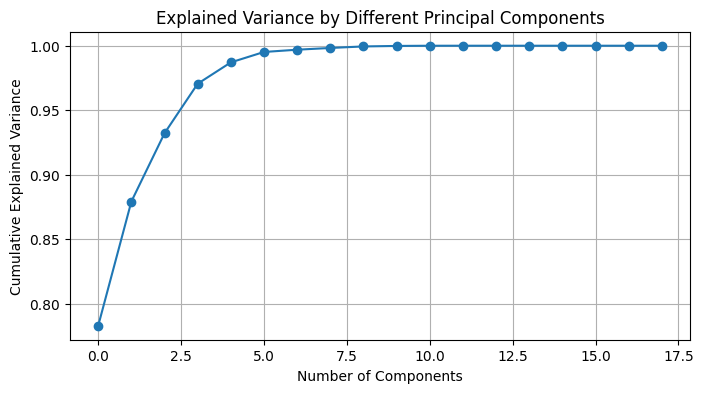

Optimal number of dimensions: 4


In [36]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(merged_df_no_nan)

pca = PCA()
principal_components = pca.fit_transform(df_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid(True)
plt.show()

optimal_dimensions = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of dimensions: {optimal_dimensions}")

In [37]:
pca = PCA(n_components=4)
principal_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(principal_components, columns=[f'PC{i}' for i in range(0, 4)])
print(df_pca.shape)
df_pca.head()

(18, 4)


,PC0,PC1,PC2,PC3
0,-5.779023,1.089468,2.749744,-1.418462
1,-4.791570,1.321057,0.245061,0.820824
2,-4.465079,0.545563,-0.090873,1.275631
3,-3.428094,-0.549421,-0.669091,0.120189
4,-3.156410,0.034463,-0.402579,0.696058


In [38]:
loadings = pca.components_
loading_matrix = pd.DataFrame(loadings, columns=merged_df_no_nan.columns, index=[f'PC{i+1}' for i in range(4)])

In [39]:
for i, pc in enumerate(loading_matrix.index):
    print(f"{pc} - Principal Component {i+1}")
    # Sort the loadings by absolute value and print them
    sorted_loadings = loading_matrix.loc[pc].abs().sort_values(ascending=False)
    print(sorted_loadings)
    print("\n")

PC1 - Principal Component 1
Smoothed GMSL (With GIA)                                   0.258395
Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)    0.258393
Global Mean Sea Level (mm, With GIA)                       0.258361
Smoothed GMSL (No GIA)                                     0.258288
Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)      0.258286
Global Mean Sea Level (mm, No GIA)                         0.258250
CO2 Average Level De-Seasonalized (PPM)                    0.256471
CO2 Average Level (PPM)                                    0.256470
Antarctic Ice Mass Lost Since 2002 (GT)                    0.255870
Average Methane Level (PPB)                                0.255405
Year                                                       0.255002
Smoothed Global Temperature Anomaly (C)                    0.254028
Ocean Warming (ZJ)                                         0.253571
Raw Global Temperature Anomaly (C)                         0.231554
Arctic Sea Ice Exten

## 5. Predictive Modeling

### 5.1. Model Selection
Discuss the selection of predictive models

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
print(merged_df.shape)

(144, 19)


In [42]:
df = merged_df.drop(columns=['Smoothed Global Temperature Anomaly (C)'])

features = df.drop(columns=['Raw Global Temperature Anomaly (C)', 'Year'])
target = df['Raw Global Temperature Anomaly (C)']

In [43]:
print(features.shape)
print(target.shape)

(144, 16)
(144,)


In [44]:
# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

print(features_scaled.shape)
features_scaled

(144, 16)


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.        , 0.        , 0.93804547, ..., 0.15933413, 0.95605614,
        0.95858572],
       [0.07613036, 0.02307544, 1.        , ..., 0.20253666, 0.97604064,
        0.97861903],
       [0.11725489, 0.28703692,        nan, ..., 0.09631391, 1.        ,
        1.        ]])

In [45]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        seq_x = data[i:i+time_steps]
        seq_y = target.iloc[i+time_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [46]:
time_window = 5
X, y = create_sequences(features_scaled, target, time_window)
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (139, 5, 16)
y.shape:  (139,)


In [47]:
max_sequence_length = X.shape[1]
print("max_sequence_length: ", max_sequence_length)

X_padded = pad_sequences(X, maxlen=max_sequence_length, padding='pre', truncating='pre', dtype='float32')
print("X_padded.shape: ", X_padded.shape)

X_train = X_padded[0:100]
y_train = y[0:100]

X_test = X_padded[100:]
y_test = y[100:]
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

max_sequence_length:  5
X_padded.shape:  (139, 5, 16)
X_train.shape:  (100, 5, 16)
y_train.shape:  (100,)
X_test.shape:  (39, 5, 16)
y_test.shape:  (39,)


In [48]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, features.shape[1])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse', sample_weight_mode=None)  # No temporal sample weights

In [50]:
# Train
X_train = np.nan_to_num(X_train, nan=0.0)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate
X_test = np.nan_to_num(X_test, nan=0.0)
mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Set: {mse}')

Epoch 1/50
3/3 [==============================] - 4s 409ms/step - loss: 0.0550 - val_loss: 0.0237
Epoch 2/50
3/3 [==============================] - 0s 76ms/step - loss: 0.0540 - val_loss: 0.0245
Epoch 3/50
3/3 [==============================] - 0s 106ms/step - loss: 0.0530 - val_loss: 0.0256
Epoch 4/50
3/3 [==============================] - 0s 59ms/step - loss: 0.0520 - val_loss: 0.0266
Epoch 5/50
3/3 [==============================] - 0s 65ms/step - loss: 0.0512 - val_loss: 0.0278
Epoch 6/50
3/3 [==============================] - 0s 101ms/step - loss: 0.0502 - val_loss: 0.0294
Epoch 7/50
3/3 [==============================] - 0s 71ms/step - loss: 0.0493 - val_loss: 0.0310
Epoch 8/50
3/3 [==============================] - 0s 82ms/step - loss: 0.0484 - val_loss: 0.0327
Epoch 9/50
3/3 [==============================] - 0s 67ms/step - loss: 0.0476 - val_loss: 0.0341
Epoch 10/50
3/3 [==============================] - 0s 43ms/step - loss: 0.0467 - val_loss: 0.0354
Epoch 11/50
3/3 [=========

In [ ]:
!git add

### 5.2. Model Training and Validation
Train models on historical data and validate their performance.

### 5.3. Forecasting
Use the models to forecast future climate trends based on historical data.

## 6. Conclusion